 ## Loading libraries and datasets ##

In [64]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import re
from scipy import stats
#pip install mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [2]:
transaction_data = pd.read_csv("QVI_transaction_data.csv", delimiter=';' )
transaction_data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,"6,3"
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,"2,9"
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,"13,8"
...,...,...,...,...,...,...,...,...
264831,43533,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,"10,8"
264832,43325,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,"4,4"
264833,43410,272,272379,270187,51,Doritos Mexicana 170g,2,"8,8"
264834,43461,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,"7,8"


In [3]:
purchase_behaviour_data = pd.read_csv("QVI_purchase_behaviour.csv",  delimiter=',')
purchase_behaviour_data

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


**LIFESTAGE:**  *Customer attribute that identifies whether a customer has a family or not and what point in life they are 
at e.g. are their children in pre-school/primary/secondary school.*


**PREMIUM_CUSTOMER:** *Customer segmentation used to differentiate shoppers by the price point of products they buy and the types of products they buy. 
It is used to identify whether customers may spend more for quality or brand or whether they will purchase the cheapest options.*


In [4]:
# Merging both DataFrames
merged_df = pd.merge(purchase_behaviour_data, transaction_data, on='LYLTY_CARD_NBR')

## Exploratory Data Analysis

In [5]:
# Dataframe's shape
merged_df.shape

(264836, 10)

In [6]:
# Checking the formats
merged_df.dtypes

LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
DATE                 int64
STORE_NBR            int64
TXN_ID               int64
PROD_NBR             int64
PROD_NAME           object
PROD_QTY             int64
TOT_SALES           object
dtype: object

In [7]:
# Converting "DATE" column to datetime and TOT_SALES to numeric format.
merged_df["DATE"] = pd.TimedeltaIndex(merged_df["DATE"], unit='d') + dt.datetime(1899, 12, 30) # Using datetime library as we are converting dates from a CSV, and Excel integer dates begin on 30 Dec 1899.

# Changing the format for "TOT_SALES" column to numeric
merged_df["TOT_SALES"] = pd.to_numeric(merged_df["TOT_SALES"].str.replace(",", "."))


In [8]:
# Looking for null entries. 
merged_df.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
dtype: int64

In [70]:
# Sorting the dataframe using the Date column.
merged_df = merged_df.sort_values(by="DATE")  

#  Resetting the index.
merged_df = merged_df.reset_index(drop=True)

merged_df

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,78115,MIDAGE SINGLES/COUPLES,Mainstream,2018-07-01,78,76138,87,Infuzions BBQ Rib Prawn Crackers 110g,2,7.6
1,220035,YOUNG SINGLES/COUPLES,Mainstream,2018-07-01,220,219501,81,Pringles Original Crisps 134g,2,7.4
2,141141,YOUNG SINGLES/COUPLES,Mainstream,2018-07-01,141,142377,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
3,59307,YOUNG SINGLES/COUPLES,Mainstream,2018-07-01,59,55832,17,Kettle Sensations BBQ&Maple 150g,2,9.2
4,39086,OLDER SINGLES/COUPLES,Mainstream,2018-07-01,39,35147,107,Smiths Crinkle Cut French OnionDip 150g,2,5.2
...,...,...,...,...,...,...,...,...,...,...
264831,156186,OLDER SINGLES/COUPLES,Premium,2019-06-30,156,157872,93,Doritos Corn Chip Southern Chicken 150g,2,7.8
264832,110247,OLDER SINGLES/COUPLES,Premium,2019-06-30,110,113041,88,Kettle Honey Soy Chicken 175g,2,10.8
264833,187156,YOUNG SINGLES/COUPLES,Mainstream,2019-06-30,187,189059,77,Doritos Corn Chips Nacho Cheese 170g,2,8.8
264834,104098,OLDER FAMILIES,Budget,2019-06-30,104,104313,114,Kettle Sensations Siracha Lime 150g,2,9.2


In [9]:
# Exploring the Products.
merged_df["PROD_NAME"].nunique()

114

In [10]:
# Listing all the products
List_Products = merged_df["PROD_NAME"].unique()

List_Products

array(['Natural Chip        Compny SeaSalt175g',
       'Red Rock Deli Chikn&Garlic Aioli 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Natural ChipCo      Hony Soy Chckn175g',
       'WW Original Stacked Chips 160g', 'Cheetos Puffs 165g',
       'Infuzions SourCream&Herbs Veg Strws 110g',
       'RRD SR Slow Rst     Pork Belly 150g',
       'Doritos Cheese      Supreme 330g', 'Doritos Mexicana    170g',
       'Old El Paso Salsa   Dip Tomato Med 300g',
       'GrnWves Plus Btroot & Chilli Jam 180g',
       'Smiths Crinkle Cut  Chips Barbecue 170g',
       'Kettle Sensations   Camembert & Fig 150g',
       'Doritos Corn Chip Southern Chicken 150g',
       'CCs Tasty Cheese    175g', 'Tostitos Splash Of  Lime 175g',
       'Kettle 135g Swt Pot Sea Salt', 'RRD Salt & Vinegar  165g',
       'Infuzions Mango     Chutny Papadums 70g',
       'Smiths Crinkle Cut  Snag&Sauce 150g',
       'Smiths Crinkle      Original 330g',
       'RRD Sweet Chilli &  Sour Cream 165g',
     

*Some product names have special characters('&') and unnecessary spaces*

In [12]:
#Removing special characters from the product names
merged_df["PROD_NAME"] = merged_df["PROD_NAME"].str.replace(r'[^a-zA-Z0-9]',' ', regex=True)

# Removing unnecessary spaces
merged_df['PROD_NAME'] = merged_df['PROD_NAME'].str.strip()

merged_df['PROD_NAME'] = merged_df['PROD_NAME'].str.replace(r'\s+', ' ', regex=True)   # \s+, matches consecutive white spaces


#### Finding products that are different than chips, by looking the repetition of words.

In [13]:
# Splitting the Product names strings into individual words and creating a list containing these words.
words_list = merged_df["PROD_NAME"].str.split(expand=True).stack()

# Counting the repetition of each word in product names.
word_counts = words_list.value_counts().reset_index()
word_counts.head(20)

,index,count
0,175g,60561
1,Chips,49770
2,150g,41633
3,Kettle,41288
4,Smiths,28860
5,Salt,27976
6,Cheese,27890
7,Pringles,25102
8,134g,25102
9,Doritos,24962


*Words like Salt, Cheese, Corn, Salsa, Cream and Chicken are appearing many times and could potentially be different products and not specifically ingredients for chips.*


In [75]:
# Creating a list of products containing the words "Salt, Cheese, Corn, Salsa, Cream or Chicken" to determine if should be removed or maintained for further analysis.

product_list  = merged_df[merged_df["PROD_NAME"].str.contains("Salt|Cheese|Corn|Salsa|Cream|Chicken")]

product_list["PROD_NAME"].unique()


array(['Kettle Sweet Chilli And Sour Cream 175g',
       'Old El Paso Salsa Dip Tomato Med 300g',
       'Smiths Crinkle Cut Salt Vinegar 170g', 'Cheezels Cheese 330g',
       'Pringles Chicken Salt Crips 134g',
       'Doritos Corn Chip Southern Chicken 150g', 'Twisties Chicken270g',
       'Kettle Honey Soy Chicken 175g', 'Woolworths Mild Salsa 300g',
       'Kettle Sea Salt And Vinegar 175g',
       'Pringles SourCream Onion 134g', 'Kettle 135g Swt Pot Sea Salt',
       'Dorito Corn Chp Supreme 380g',
       'Red Rock Deli Sp Salt Truffle 150G',
       'Smith Crinkle Cut Mac N Cheese 150g',
       'Pringles Sthrn FriedChicken 134g',
       'Grain Waves Sour Cream Chives 210G', 'Twisties Cheese 270g',
       'Twisties Cheese Burger 250g', 'Thins Chips Salt Vinegar 175g',
       'RRD Pc Sea Salt 165g', 'Doritos Corn Chips Nacho Cheese 170g',
       'Doritos Salsa Mild 300g', 'Smiths Thinly Cut Roast Chicken 175g',
       'Cheezels Cheese Box 125g',
       'Doritos Corn Chip Mexican Ja

*We can notice that only the products containing the word 'Salsa' should be removed from the transaction DataFrame as they are not chips.*

In [16]:
# Removing from the DataFrame the products where the word salsa is found.
merged_df = merged_df[~merged_df["PROD_NAME"].str.contains("Salsa")]

#### Exploring the dataset for outliers

In [17]:
merged_df.describe()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,2.467420e+05,246742,246742.000000,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,1.355310e+05,2018-12-30 01:19:01.211468288,135.051098,1.351311e+05,56.351789,1.908062,7.321322
min,1.000000e+03,2018-07-01 00:00:00,1.000000,1.000000e+00,1.000000,1.000000,1.700000
25%,7.001500e+04,2018-09-30 00:00:00,70.000000,6.756925e+04,26.000000,2.000000,5.800000
50%,1.303670e+05,2018-12-30 00:00:00,130.000000,1.351830e+05,53.000000,2.000000,7.400000
75%,2.030840e+05,2019-03-31 00:00:00,203.000000,2.026538e+05,87.000000,2.000000,8.800000
max,2.373711e+06,2019-06-30 00:00:00,272.000000,2.415841e+06,114.000000,200.000000,650.000000
std,8.071528e+04,NaN,76.787096,7.814772e+04,33.695428,0.659831,3.077828


*The average number of products purchased is 1.90. However, there is a transaction with a maximum quantity of 200. Same thing is happening with the TOT_SALES column (mean=7.32, max=650.00)*

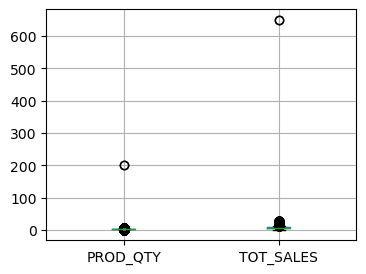

In [18]:
# Creating a boxplot to visualize outliers.
merged_df.boxplot(column=['PROD_QTY','TOT_SALES'], figsize=(4,3))

plt.show()

In [19]:
# Inspecting the data for those two outliers
merged_df[(merged_df['PROD_QTY'] == 200) | (merged_df['LYLTY_CARD_NBR'] == 226000)]


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
221625,226000,OLDER FAMILIES,Premium,2018-08-19,226,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
221626,226000,OLDER FAMILIES,Premium,2019-05-20,226,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


*Both were bought by  the same customer (LYLTY_CARD_NBR = 226000) and on both occasions the product was "Dorito Corn Chp Supreme 380g"*

In [21]:
# Exploring the purchases from this customer
merged_df[merged_df['LYLTY_CARD_NBR'] == 226000]

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
221625,226000,OLDER FAMILIES,Premium,2018-08-19,226,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
221626,226000,OLDER FAMILIES,Premium,2019-05-20,226,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


*This customer only has two transactions and does not represent the regular customer purchase behavior*

In [22]:
# Excluding this customer from further analysis.
merged_df = merged_df[merged_df['LYLTY_CARD_NBR'] != 226000]

### Number of products bought by Transaction

In [29]:
# Grouping the total number of products by transaction id
Total_Prod_by_Txn = merged_df.groupby('TXN_ID')['PROD_QTY'].sum()

# New DataFrame with unique transaction IDs and their total product quantities
products_by_transaction_id = pd.DataFrame({'TXN_ID': Total_Prod_by_Txn.index, 'Total_PROD_QTY': Total_Prod_by_Txn.values})

# Counting of customer buying one packet or multiple packets
MULT_PCKT_BUYER = 0
SINGLE_PCKT_BUYER = 0

for id in products_by_transaction_id.index:
    if products_by_transaction_id.loc[id,'Total_PROD_QTY'] < 2:
        SINGLE_PCKT_BUYER += 1
    else:
        MULT_PCKT_BUYER += 1

# Printing the calculation.

print("In ", MULT_PCKT_BUYER,"transactions, customers bought more than one packet of chips.",SINGLE_PCKT_BUYER, "transactions are for only one packet of chips.")

In  219936 transactions, customers bought more than one packet of chips. 25319 transactions are for only one packet of chips.


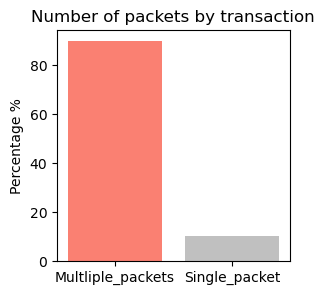

In [28]:
# Calculating the percentages of transactions in which the customers bought only one packet of chips or multiple.
Single_porcentage_calc = (SINGLE_PCKT_BUYER / products_by_transaction_id['TXN_ID'].count())*100
Mult_porcentage_calc = MULT_PCKT_BUYER / products_by_transaction_id['TXN_ID'].count()*100

# Displaying the values in a chart.
plt.figure(figsize=(3,3))
plt.bar(['Multliple_packets', 'Single_packet'], [Mult_porcentage_calc, Single_porcentage_calc], color=['salmon','silver'])
plt.ylabel('Percentage %')
plt.title('Number of packets by transaction')
plt.show()

*In only 10% of all transactions customers are buying one single packet, 90% of the transactions are for more than one packet of chips.*

### Trends by Date

In [30]:
# Grouping the transactions by date.
transactions_by_date = merged_df.groupby("DATE")["TOT_SALES"].sum().reset_index()

transactions_by_date


,DATE,TOT_SALES
0,2018-07-01,4920.1
1,2018-07-02,4877.0
2,2018-07-03,4954.7
3,2018-07-04,4968.1
4,2018-07-05,4682.0
...,...,...
359,2019-06-26,4829.7
360,2019-06-27,4941.3
361,2019-06-28,4876.6
362,2019-06-29,5177.6


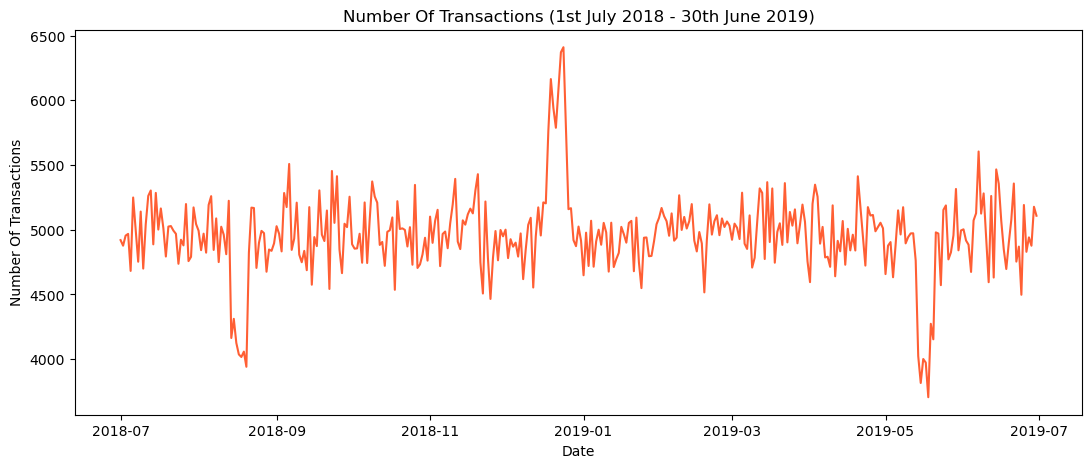

In [33]:
# Plotting a graph of the number of sales for each date.

plt.figure(figsize=(13, 5))
plt.plot(transactions_by_date["DATE"], transactions_by_date["TOT_SALES"], color="#ff5f34")
plt.title("Number Of Transactions (1st July 2018 - 30th June 2019)")
plt.xlabel("Date")
plt.ylabel("Number Of Transactions")

plt.show()


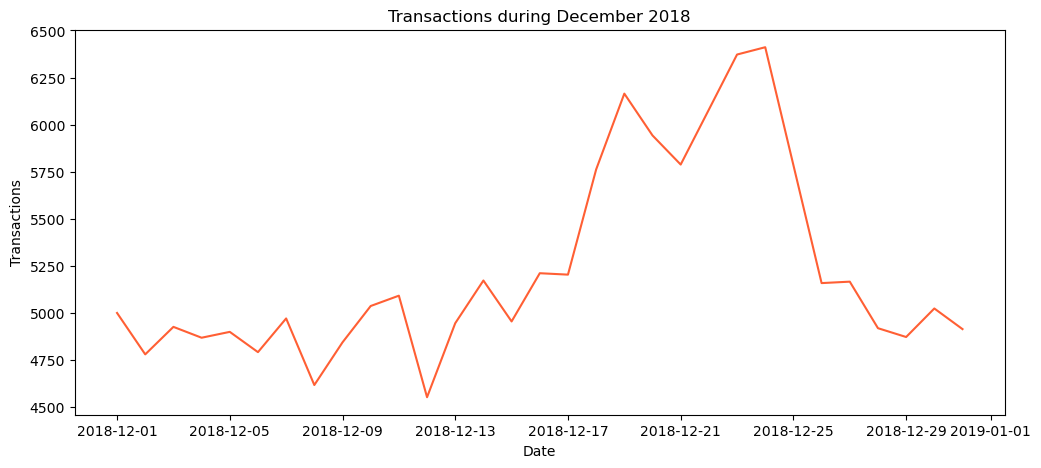

In [34]:
##### Creating a new graph of the sales for December 2018.

plt.figure(figsize=(12, 5))
plt.plot(transactions_by_date["DATE"][transactions_by_date["DATE"].dt.month==12], transactions_by_date["TOT_SALES"][transactions_by_date["DATE"].dt.month==12], color="#ff5f34")
plt.title("Transactions during December 2018")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.show()

* Sales increased on December 2018 as Christmas day was approaching.*

In [38]:
AVG_Sales = transactions_by_date["TOT_SALES"].mean()

Max_sales = transactions_by_date["TOT_SALES"].max()


print("Average daily sales:",AVG_Sales, "peak sales during Dicember:",Max_sales)

Average daily sales: 4959.279395604395 peak sales during Dicember: 6410.9


#### Sizes of the packets

In [39]:
# Creating a new column with the packets sizes, extracted from the 'PROD_NAME' column. 
merged_df['SIZE'] = merged_df['PROD_NAME'].str.extract(r'([0-9]+[g])') # Using regular expressions(number followed by 'g').

# Calculating the number of packets sold by size.
pack_size = merged_df.groupby("SIZE")["PROD_QTY"].sum()

# Descending order
pack_size = pack_size.sort_values(ascending=False)

pack_size = pack_size.reset_index()

pack_size

,SIZE,PROD_QTY
0,175g,123692
1,150g,73818
2,134g,48019
3,110g,42835
4,170g,38088
5,165g,29051
6,330g,23999
7,380g,12273
8,270g,12049
9,200g,8425


In [40]:
# Calculating the total number of packets sold.
total_qty = pack_size["PROD_QTY"].sum()

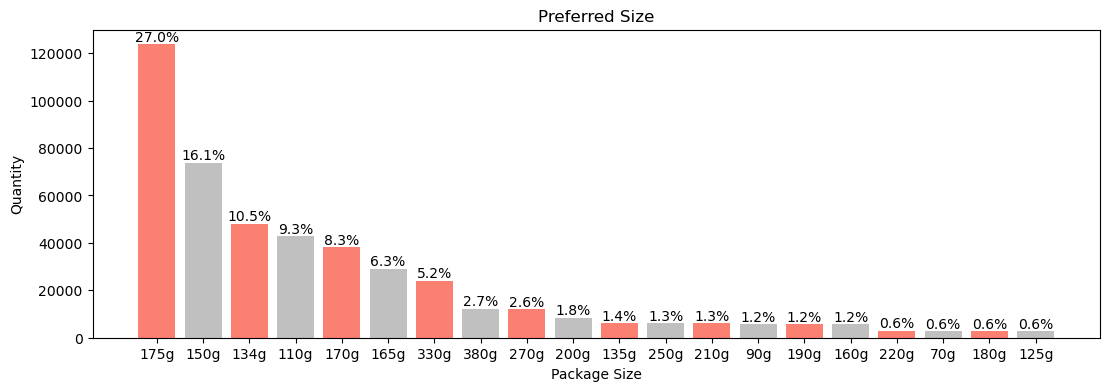

In [41]:
# Plotting graph of the distribution of products by size.
plt.figure(figsize=(13, 4))
plt.bar(pack_size["SIZE"], pack_size["PROD_QTY"], color=['salmon','silver'])
plt.title("Preferred Size")
plt.xlabel("Package Size")
plt.ylabel("Quantity")

# Percentage of products sold of each size
for i, qty in enumerate(pack_size["PROD_QTY"]):
    percentage = (qty / total_qty) * 100
    plt.text(i, qty, f"{percentage:.1f}%", ha='center', va='bottom')


plt.show()


*In general 175g seems to be the preferred packet size. representing 27% of the products sold. Let's see if 175 grams is the preferred size due to it's price.*

In [43]:
# Finding the price for each unity.
merged_df['UNI_PRICE'] = merged_df['TOT_SALES'] / merged_df['PROD_QTY']

# Calculating the mean price for each packet size.
price_by_size = merged_df.groupby("SIZE")["UNI_PRICE"].mean()
price_by_size = price_by_size.sort_values(ascending=False)
price_by_size

SIZE
380g    6.132318
330g    5.700000
270g    4.600000
250g    4.300000
135g    4.200000
175g    3.851491
170g    3.846597
150g    3.815304
110g    3.799915
134g    3.699838
210g    3.599318
165g    3.486331
180g    3.100000
190g    2.540735
70g     2.400000
220g    2.300000
125g    2.100000
160g    1.900000
200g    1.900000
90g     1.700000
Name: UNI_PRICE, dtype: float64

*175g is neither the cheapest product nor the most expensive.*

### Product with more sales.

In [92]:
# Calculating the number of packets sold of each Product.
Top_sellers_prod = merged_df.groupby("PROD_NAME")["PROD_QTY"].sum()

# Sorting values in descending order
Top_sellers_prod = Top_sellers_prod.sort_values(ascending= False)

print(Top_sellers_prod.head(10))

PROD_NAME
Kettle Mozzarella Basil Pesto 175g          6381
Kettle Tortilla ChpsHny Jlpno Chili 150g    6309
Cobs Popd Sea Salt Chips 110g               6277
Cobs Popd Swt Chlli Sr Cream Chips 110g     6256
Tostitos Splash Of Lime 175g                6234
Tyrrells Crisps Ched Chives 165g            6227
Kettle 135g Swt Pot Sea Salt                6212
Infuzions Thai SweetChili PotatoMix 110g    6206
Thins Potato Chips Hot Spicy 175g           6185
Doritos Corn Chips Cheese Supreme 170g      6180
Name: PROD_QTY, dtype: int64


#### Revenue by product.

In [44]:
# Grouping the total sales by product
Revenue_by_prod = merged_df.groupby("PROD_NAME")["TOT_SALES"].sum()

#Values in descending order
Revenue_by_prod = Revenue_by_prod.sort_values(ascending= False)

print(Revenue_by_prod.head(10))

PROD_NAME
Dorito Corn Chp Supreme 380g               39052.0
Smiths Crnkle Chip Orgnl Big Bag 380g      36367.6
Smiths Crinkle Chips Salt Vinegar 330g     34804.2
Kettle Mozzarella Basil Pesto 175g         34457.4
Smiths Crinkle Original 330g               34302.6
Cheezels Cheese 330g                       34296.9
Doritos Cheese Supreme 330g                33390.6
Kettle Sweet Chilli And Sour Cream 175g    33031.8
Kettle Original 175g                       32740.2
Kettle Sea Salt And Vinegar 175g           32589.0
Name: TOT_SALES, dtype: float64


In [45]:
#Calculating the total sales for the product with more sales.
Top_Seller_Data = merged_df[merged_df["PROD_NAME"].str.contains("Kettle Mozzarella Basil Pesto 175g")]

Top_Seller_Total = Top_Seller_Data["TOT_SALES"].sum()


# Calculating the total sales for the most profitable product
Data_Dorito = merged_df[merged_df["PROD_NAME"].str.contains("Dorito Corn Chp Supreme 380g")]

Sales_Dorito = Data_Dorito["TOT_SALES"].sum()

Difference = 100-(Sales_Dorito/Top_Seller_Total)*100

print(Difference)

-13.334145930917614


*The product that was sold the most was "Kettle Mozzarella Basil Pesto 175g" however it's in 4th position within the product's ranking in terms of revenue.*

*Meanwhile "Dorito Corn Chp Supreme 380g" is the more profitable product, generating $39052 (13% more than the top seller product)*

### Customer segments analysis

*  Calculate the sales distribution by each customer segment.
*  Calculate the number of customers by segment (life stage and premium).
*  Find the average number of packs bought per customer by segment.
*  Average product price by customer segment.

### Sales by segment $

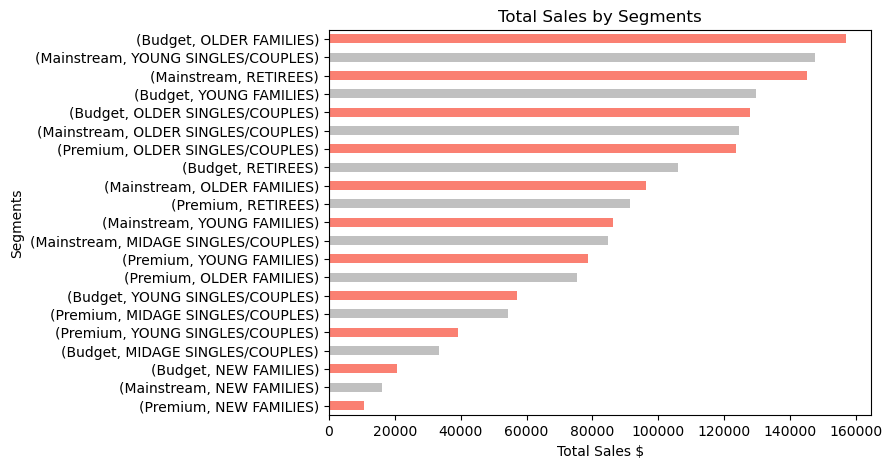

In [46]:
# Computing the total sales by LIFESTAGE and PREMIUM_CUSTOMER 
sales_by_segment = merged_df.groupby(["PREMIUM_CUSTOMER", "LIFESTAGE"])["TOT_SALES"].sum()

# Sorting values
sales_by_segment = sales_by_segment.sort_values(ascending=True)

# Displaying the sales in a chart
sales_by_segment.plot.barh(figsize=(7,5), color=['salmon','silver'])

plt.xlabel('Total Sales $')
plt.ylabel('Segments')
plt.title('Total Sales by Segments')
plt.show()

*Top sales are mainly coming from Budget Older families, Mainstream - young Singles/couples and Mainstream  retirees.*

### Number of customers by segment 

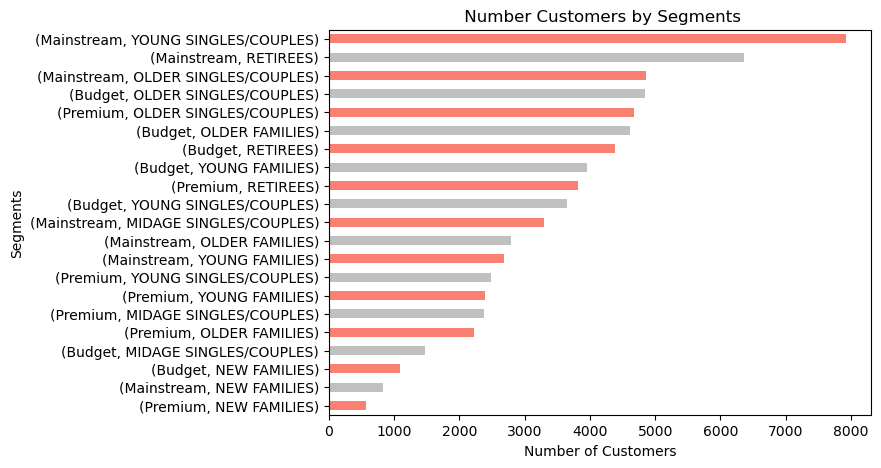

In [48]:
# Computing the number of customers for each Premium segment using unique loyalty card numbers.
premium_customer_count = merged_df.groupby(["PREMIUM_CUSTOMER", "LIFESTAGE"])["LYLTY_CARD_NBR"].nunique()

# Sorting values
premium_customer_count = premium_customer_count.sort_values(ascending=True)


# Ploting the results
premium_customer_count.plot.barh(figsize=(7,5), color=['salmon','silver'])
plt.xlabel('Number of Customers')
plt.ylabel('Segments')
plt.title(' Number Customers by Segments')
plt.show()

For the Mainstream - young singles/couples and Mainstream - Retirees there are a high number of customers who buy
chips. Therefore, there are more sales for these customer segments. However, for the Budget - Older families segment it does not seem to be the case.
Higher sales may also be driven by more units of chips being bought per customer.

### Average number of units per customer by Segment.


In [97]:
# Grouping the total number of products by segment.
nbr_chips_by_segment = merged_df.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["PROD_QTY"].sum()

cx_by_segments = merged_df.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["LYLTY_CARD_NBR"].nunique()

# Grouping the total number of transactions by each group.
avg_products_by_customer = nbr_chips_by_segment/cx_by_segments

# Descending order
avg_products_by_customer = avg_products_by_customer.sort_values(ascending=False)

print(avg_products_by_customer)

LIFESTAGE               PREMIUM_CUSTOMER
OLDER FAMILIES          Mainstream          9.255380
                        Budget              9.076773
                        Premium             9.071717
YOUNG FAMILIES          Budget              8.722995
                        Premium             8.716013
                        Mainstream          8.638361
OLDER SINGLES/COUPLES   Budget              6.781398
                        Premium             6.769543
                        Mainstream          6.712021
MIDAGE SINGLES/COUPLES  Mainstream          6.432080
RETIREES                Budget              6.141847
                        Premium             6.103358
MIDAGE SINGLES/COUPLES  Premium             6.078514
                        Budget              6.026459
RETIREES                Mainstream          5.925920
NEW FAMILIES            Mainstream          4.891566
                        Budget              4.821527
                        Premium             4.815652
YOUNG

Older families and young families in general buy more chips per customer.

### Average price per unit

In [49]:
# Calculating the average price payed by each segment.
avg_price_by_segment = merged_df.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["UNI_PRICE"].mean()

#sorting values
avg_price_by_segment = avg_price_by_segment.sort_values(ascending = False)

print(avg_price_by_segment)

LIFESTAGE               PREMIUM_CUSTOMER
YOUNG SINGLES/COUPLES   Mainstream          4.065642
MIDAGE SINGLES/COUPLES  Mainstream          3.994241
RETIREES                Budget              3.924404
                        Premium             3.920942
NEW FAMILIES            Budget              3.917688
                        Mainstream          3.916133
OLDER SINGLES/COUPLES   Premium             3.893182
                        Budget              3.882096
NEW FAMILIES            Premium             3.872110
RETIREES                Mainstream          3.844294
OLDER SINGLES/COUPLES   Mainstream          3.814665
MIDAGE SINGLES/COUPLES  Premium             3.770698
YOUNG FAMILIES          Premium             3.762150
                        Budget              3.760737
OLDER FAMILIES          Budget              3.745340
MIDAGE SINGLES/COUPLES  Budget              3.743328
OLDER FAMILIES          Mainstream          3.737077
YOUNG FAMILIES          Mainstream          3.724533
OLDER

Mainstream YOUNG SINGLES/COUPLES and MIDAGE SINGLES/COUPLES are more willing to pay more per packet compared to their budget and premium counterparts. This may be due to premium shoppers buy chips mainly for entertainment purposes rather than their regular consumption.

## Statistical Tests

Checking if the difference in average price per unit is statistically significant as the difference is not large.

#### Null and alternative hypotheses:

* $H_0$: There is no statistical difference between average price per unit of products bought by the Mainstream and the counterparts (budget and premium) for YOUNG SINGLES/COUPLES.
* $H_A$: Customers form the YOUNG SINGLES/COUPLES Mainstream segment are paying more for each product than the rest of the segments (YOUNG SINGLES/COUPLES budget and premium ).

In [53]:
# Getting the samples for YOUNG SINGLES/COUPLES

young_mainstream = merged_df[((merged_df["LIFESTAGE"] == "YOUNG SINGLES/COUPLES") | (merged_df["LIFESTAGE"] == "MIDAGE SINGLES/COUPLES")) & (merged_df["PREMIUM_CUSTOMER"] == "Mainstream")]

young_budget_premium = merged_df[((merged_df["LIFESTAGE"] == "YOUNG SINGLES/COUPLES") | (merged_df["LIFESTAGE"] == "MIDAGE SINGLES/COUPLES")) & ((merged_df["PREMIUM_CUSTOMER"] == "Budget") | (merged_df["PREMIUM_CUSTOMER"] == "Premium"))]


# Setting a Significance level of 5%

significance_lvl = 0.05

# Getting the p-value 
stats.ttest_ind(a= young_mainstream["UNI_PRICE"], b= young_budget_premium["UNI_PRICE"], alternative = 'greater', equal_var=False)     


TtestResult(statistic=37.6243885962295, pvalue=3.4836771165090696e-306, df=54791.093927403155)

With a p-value of 3.48e-306, which is less than 0 and a significance level of 5% we can to reject the null hypothesis. There is a statistical difference and YOUNG and MIDAGE SINGLES/COUPLES are paying significantly more than budget or premium customers from the same segment.

### Affinity Analysis
##### Exploring trends for specific customer segments  that contribute the most to sales to retain them or further increase sales.

##### Let's look at Mainstream - young singles/couples to find out if they tend to buy a particular brand of chips.

In [54]:
# Brand names.

# Creating a new column with the first word for each string
merged_df["BRAND"] = merged_df["PROD_NAME"].str.split().str[0]

# Checking the brand names
print(merged_df["BRAND"].unique())

['Natural' 'Red' 'Grain' 'WW' 'Cheetos' 'Infuzions' 'RRD' 'Doritos'
 'GrnWves' 'Smiths' 'Kettle' 'CCs' 'Tostitos' 'Cobs' 'Burger' 'Woolworths'
 'Thins' 'Tyrrells' 'Smith' 'Cheezels' 'Twisties' 'Sunbites' 'Snbts'
 'Pringles' 'French' 'Infzns' 'Dorito' 'NCC']


In [55]:
# Adding a funtion to fix the brand's names as some are incomplete or are expressed as abbreviations.
def correct_misspellings(line):
    brand = line["BRAND"]
    if brand == "Dorito":
        return "Doritos"
    elif brand == "Grain" or brand == "GrnWves":
        return "Grain Waves"
    elif brand == "RRD" or brand == "Red":
        return "Red Rock Deli"
    elif brand == "Smith":
        return "Smiths"
    elif brand == "Old":
        return "Old El Paso"
    elif brand == "Snbts":
        return "Sunbites"
    elif brand == "Infzns":
        return "Infuzions"
    elif brand == "WW":
        return "Woolworths"
    elif brand == "Natural" or brand == "NCC":
        return "Natural Chip Co"
# Based on a research online noticed that Burger Rings is a product owned by Smiths.
    elif brand == "Burger":
        return "Smiths"
# French Fries Original Chips is a product of Woolworths, not a brand.
    elif brand == "French":
        return "Woolworths"
    else:
        return brand

# Applying the function
merged_df["BRAND"] = merged_df.apply(lambda line: correct_misspellings(line), axis=1)

# Confirming the changes
print(merged_df["BRAND"].unique())

['Natural Chip Co' 'Red Rock Deli' 'Grain Waves' 'Woolworths' 'Cheetos'
 'Infuzions' 'Doritos' 'Smiths' 'Kettle' 'CCs' 'Tostitos' 'Cobs' 'Thins'
 'Tyrrells' 'Cheezels' 'Twisties' 'Sunbites' 'Pringles']


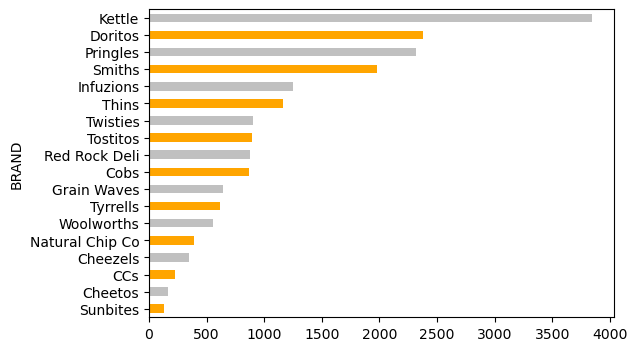

In [56]:
# Creating a visual of what brands mainstream young singles/couples are purchasing the most, for a general indication.

# Filtering the data to only show young singles/couples data.
Brands_Young_Singles_Couples =  merged_df["BRAND"][(merged_df["LIFESTAGE"] == "YOUNG SINGLES/COUPLES") & (merged_df["PREMIUM_CUSTOMER"] == "Mainstream") ]

# Resetting the Index
Brands_Young_Singles_Couples = Brands_Young_Singles_Couples.reset_index()

# Grouping the sum of each brand bought by  young singles/couples
Brands_Young_Singles_Couples = Brands_Young_Singles_Couples["BRAND"].value_counts()
# Descending Order 

Brands_Young_Singles_Couples = Brands_Young_Singles_Couples.sort_values()

Brands_Young_Singles_Couples.plot.barh(figsize=(6,4), color=["Orange","silver"])
plt.show()




### Affinity Analysis

In [57]:
# Creating a temporal copy of the DataFrame 

copy_df = merged_df.copy()

# Creating a new column containing the segments names

copy_df["SEGMENTS"] = copy_df["PREMIUM_CUSTOMER"] + "-" + copy_df["LIFESTAGE"]


In [58]:
# Getting the dummies from segments ands brands
Segments = pd.get_dummies(copy_df["SEGMENTS"])
Brands = pd.get_dummies(copy_df["BRAND"])

# Joining them
Segments_Brands = Segments.join(Brands)

Segments_Brands


,Budget-MIDAGE SINGLES/COUPLES,Budget-NEW FAMILIES,Budget-OLDER FAMILIES,Budget-OLDER SINGLES/COUPLES,Budget-RETIREES,Budget-YOUNG FAMILIES,Budget-YOUNG SINGLES/COUPLES,Mainstream-MIDAGE SINGLES/COUPLES,Mainstream-NEW FAMILIES,Mainstream-OLDER FAMILIES,...,Natural Chip Co,Pringles,Red Rock Deli,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,Woolworths
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264830,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
264831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
264832,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
264833,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [62]:
# Using the Apriori algorithm
freq_brands = apriori(Segments_Brands, min_support=0.01,  use_colnames=True)

# Creating rules
rules = association_rules(freq_brands, metric="lift", min_threshold=0.9)

# Sorting the values using the confidence.
rules.sort_values('confidence', ascending = False, inplace = True)


In [63]:
unique_segments = copy_df["SEGMENTS"].unique()

# Applying rules 
rules[rules["antecedents"].apply(lambda x: list(x)).apply(lambda x: x in unique_segments)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
16,(Mainstream-YOUNG SINGLES/COUPLES),(Kettle),0.079209,0.167334,0.015579,0.196684,1.175400,0.002325,1.036537,0.162062
7,(Budget-RETIREES),(Kettle),0.057652,0.167334,0.010505,0.182214,1.088926,0.000858,1.018196,0.086660
5,(Budget-OLDER SINGLES/COUPLES),(Kettle),0.069596,0.167334,0.012422,0.178488,1.066658,0.000776,1.013578,0.067167
18,(Premium-OLDER SINGLES/COUPLES),(Kettle),0.067115,0.167334,0.011944,0.177959,1.063495,0.000713,1.012925,0.064000
12,(Mainstream-RETIREES),(Kettle),0.080935,0.167334,0.013723,0.169554,1.013269,0.000180,1.002674,0.014248
10,(Mainstream-OLDER SINGLES/COUPLES),(Kettle),0.069146,0.167334,0.011490,0.166168,0.993034,-0.000081,0.998602,-0.007479
9,(Budget-YOUNG FAMILIES),(Kettle),0.071991,0.167334,0.011117,0.154422,0.922837,-0.000930,0.984730,-0.082654
0,(Budget-OLDER FAMILIES),(Kettle),0.087193,0.167334,0.013455,0.154318,0.922216,-0.001135,0.984609,-0.084586
3,(Budget-OLDER FAMILIES),(Smiths),0.087193,0.129355,0.012592,0.144418,1.116446,0.001313,1.017605,0.114263
15,(Mainstream-RETIREES),(Smiths),0.080935,0.129355,0.010088,0.124637,0.963528,-0.000382,0.994610,-0.039557


*Kettle seams to be the preferred across most customer segments. However for Budget-OLDER FAMILIES and Mainstream-Retirees, "Smiths" is the preferred brand.*

### Conclusion:

1. A significant majority of customers, 90%, tend to purchase multiple packs of chips in a single transaction, indicating a strong preference for bulk buying.
2. Seasonal trends show an increase in transactions during December, likely linked to Christmas celebrations, with peak sales reaching \\$6410.9.
4. The 175g chip pack size emerges as the most popular choice among consumers, accounting for 27% of total sales and over 120,000 units sold.
5. "Kettle Mozzarella Basil Pesto 175g" leads product sales with 6381 units sold, closely followed by "Kettle’s Tortilla Chips Honey Jalapeño Chili 150g" at 6309 units sold. Kettle dominates the market, being the preferred brand across most customer segments. However, exceptions exist for Budget-OLDER FAMILIES and Mainstream-RETIREES, which tend to buy products from the brand Smiths.
6. Despite Kettle and Smiths being the preferred brands, Dorito Corn Chip Supreme 380g is the top-selling product, generating \\$39052 in revenue, which is 13% higher than Kettle's best-selling product.
7. Sales are driven by three customer segments: Budget Older-Families, Mainstream Young-Singles/Couples, and Retirees. The Budget Older-Families segment shows a higher quantity of purchases per transaction, setting it apart from the other segments. For Mainstream Young-Singles/Couples and Retirees, sales correspond to the customer count within those segments.